In [ ]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# for my pc
url_living_to_all = "Planify_Graphs_Scaled/Planify_Graphs_Scaled/Graphs_living_to_all.pkl"
url_boundary = "Planify_Graphs_Scaled/Planify_Graphs_Scaled/boundaries.pkl"

# # for kaggle
# url_real = "/kaggle/input/planify-graphs-all-forms/graphs/Graphs_real.pkl"
# url_boundary = "/kaggle/input/planify-graphs-all-forms/graphs/boundaries.pkl"

In [31]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}
def draw_graph_nodes(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')

    
    nx.draw_networkx_nodes(G, pos=pos, node_size=scales, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos, edge_color='b');
    nx.draw_networkx_labels(G, pos=pos, font_size=8);

    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    
    # # Drawing the graph inside a good boundary.
    # x_coords  = [pos[node][0] for node in pos]
    # y_coords  = [pos[node][1] for node in pos]
    # threshold = max(scales) / 100
    
    # plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    

def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    # nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos)
    
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    
    
# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')
    
    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()
        
        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()
        
        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph
            
        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
            min_y = min_y_in_graph
            
    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values


def get_all_x_y(graphs):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []
    for i, G in tqdm(enumerate(graphs), desc="getting all Xs, Ys", total=len(graphs)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())
            

    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()
    

def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');

In [32]:
with open(url_living_to_all, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)

Graph with 8 nodes and 7 edges


In [33]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)
    
b = boundaries[1911]
print(b)

Graph with 9 nodes and 9 edges


In [36]:
def convert_networkx_Graphs_to_pyTorchGraphs(G):
    """ Converting networkx graphs to pytorchGeo graphs
    """
    features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    return G_new

Graphs_pyTorch = list(map(convert_networkx_Graphs_to_pyTorchGraphs, Graphs))

Graphs_pyTorch[0]

KeyboardInterrupt: 

In [35]:
def convert_networkx_Boundaries_to_pyTorchGraphs(b):
    """Converting networkx boundary graphs to PyTorchGeo graphs
    """
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    return b_new

Boundaries_pyTorch = list(map(convert_networkx_Boundaries_to_pyTorchGraphs, boundaries))

Boundaries_pyTorch[0]

Data(edge_index=[2, 18], x=[9, 3], edge_attr=[18, 1])

In [37]:
G_x, G_y = get_all_x_y(Graphs_pyTorch)
G_x.max(), G_y.max(), G_x.min(), G_y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:05<00:00, 14664.76it/s]


(247.42583732057415, 247.84313725490196, 10.666666666666666, 8.577319587628866)

In [38]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
G_x_mean = G_x.mean()
G_y_mean = G_y.mean()
G_x_std  = G_x.std()
G_y_std  = G_y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [39]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  7.0000, 163.5824, 101.4260],
        [  7.0000, 134.9086, 201.0376]], dtype=torch.float64)


100%|██████████| 80787/80787 [00:02<00:00, 32322.59it/s]

After: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  1.0000, 163.5824, 101.4260],
        [  1.0000, 134.9086, 201.0376]], dtype=torch.float64)


In [40]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    
    # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
    # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly 
    # multiply the means using the idea of "Broadcasting".
    G.x[:, 1:] = (G.x[:, 1:] - torch.tensor([G_x_mean, G_y_mean])) / torch.tensor([G_x_std, G_y_std])
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:05<00:00, 14023.12it/s]


In [41]:
return_to_real = Graphs_pyTorch[1].x[:, [-2, -1]] * torch.tensor([G_x_std, G_y_std]) + torch.Tensor([G_x_mean, G_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")

Now, we could return back to real values: 
tensor([[114.4449, 153.2065],
        [207.2296, 196.9931],
        [ 26.6358,  34.7746],
        [222.7052, 140.5780],
        [117.2607, 101.8013],
        [163.5824, 101.4260],
        [134.9086, 201.0376]], dtype=torch.float64)


In [42]:
B_x, B_y = get_all_x_y(Boundaries_pyTorch)
B_x.max(), B_y.max(), B_x.min(), B_y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:07<00:00, 11105.85it/s]


(340.0875912408759, 306.0, -57.6, -86.6771653543307)

In [43]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
B_x_mean = B_x.mean()
B_y_mean = B_y.mean()
B_x_std  = B_x.std()
B_y_std  = B_y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [44]:
for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):
    
    # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
    # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly 
    # multiply the means using the idea of "Broadcasting".
    b.x[:, 1:] = (b.x[:, 1:] - torch.tensor([B_x_mean, B_y_mean])) / torch.tensor([B_x_std, B_y_std])

100%|██████████| 80787/80787 [00:02<00:00, 31392.07it/s]


In [45]:
return_to_real = Boundaries_pyTorch[1].x[:, [-2, -1]] * torch.tensor([B_x_std, B_y_std]) + torch.Tensor([B_x_mean, B_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")

Now, we could return back to real values: 
tensor([[ 3.6994e+00,  2.5008e+02],
        [ 1.0136e+02,  2.5008e+02],
        [ 2.5230e+02,  2.4712e+02],
        [ 2.5230e+02,  1.1986e+02],
        [ 1.9755e+02,  1.1986e+02],
        [ 1.9755e+02,  6.6590e+01],
        [ 4.9572e+01,  6.6590e+01],
        [ 4.9572e+01, -1.0978e-06],
        [ 3.6994e+00, -1.0978e-06],
        [ 8.6566e+01,  6.8069e+01]], dtype=torch.float64)


In [46]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(self.device)
        B = self.Boundaries[index].clone().to(self.device)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)
        
        # shuffling nodes inside the same graph
        # permutation = torch.randperm(G.num_nodes).to(self.device)
        
        # G.x = G.x[permutation]
        # G.edge_index = permutation[G.edge_index]
        # G.rec_w = G.rec_w[permutation]
        # G.rec_h = G.rec_h[permutation]
        # G.edge_attr = G.edge_attr[permutation]
        
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        graphs = {
            'G': G,
            'B': B
        }
        
        return graphs
edge = int(len(Graphs_pyTorch) * 0.8)
batch_size = 32
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10], Boundaries_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:], Boundaries_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"Train dataset: {len(train_dataset)}, Val dataset: {len(val_dataset)}, Test dataset: {len(test_dataset)}")

Train dataset: 64629, Val dataset: 16148, Test dataset: 10


In [47]:
# Saving model function
import os

checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'Best_model_V3.pt')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)
    
    print('Model saved :)')

In [50]:
class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        
        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)
        
        input_of_conv2   = num_graph_node_features + 32*4
        self.graph_conv2 = GATConv(input_of_conv2, 32, heads=8)
        
        input_of_conv3   = num_graph_node_features + 32*8
        self.graph_conv3 = GATConv(input_of_conv3, 64, heads=8)
        
        input_of_conv4   = num_graph_node_features + 64*8
        self.graph_conv4 = GATConv(input_of_conv4, 128, heads=8)
        # self.graph_conv5 = GATConv(128*8, 128, heads=8)
        # self.graph_conv6 = GATConv(128*8, 128, heads=16)
        # self.graph_conv7 = GATConv(128*16, 256, heads=16)
        # self.graph_conv8 = GATConv(256*16, 256, heads=16)
        shape_of_graphs_befor_concatination = num_graph_node_features + 128*8
        
        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)
        input_of_boundary_conv2 = 32*4 + num_boundary_node_features
        self.boundary_conv2 = GATConv(input_of_boundary_conv2, 32, heads=8)
        # self.boundary_conv3 = GATConv(32*8, 64, heads=8)
        # self.boundary_conv4 = GATConv(64*8, 128, heads=8)
        # self.boundary_conv5 = GATConv(128*8, 128, heads=8)
        shape_of_boundary_befor_concatination = num_boundary_node_features + 32 * 8
        
        # Output of graph_conv8 + output of boundary_conv5 + 2 step connection from real nodes and boundary nodes
        inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
        self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)
        # self.Concatination2  = GATConv(128*8, 64, heads=8)
        # self.Concatination3  = GATConv(64*8, 64, heads=8)
        # self.Concatination4  = GATConv(64*8, 32, heads=8)
        # self.Concatination5  = GATConv(32*8, 32*4)
        
        # self.lin1 = nn.Linear(inputs_concatination, 256)
        # self.lin2 = nn.Linear(256, 32)

        self.width_layer1  = nn.Linear(128*8, 128)
        self.height_layer1 = nn.Linear(128*8, 128)
        
        # self.width_layer2  = nn.Linear(256, 128)
        # self.height_layer2 = nn.Linear(256, 128)
        
        # self.width_layer3  = nn.Linear(128, 32)
        # self.height_layer3 = nn.Linear(128, 32)
        
        # self.width_layer4  = nn.Linear(32, 8)
        # self.height_layer4 = nn.Linear(32, 8)
        
        self.width_output  = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)
        
        
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr, g_batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch
        
        NUM_OF_NODES = x_graph.shape[0]
        # During testing, as we input only one graph.
        if g_batch == None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if b_batch == None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        
        x_graph_res = x_graph
        x_boundary_res = x_boundary
        
        # Passing the graph throught a message passing to embed its features
        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph) # Concatinate with step connection from real values.
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        
        x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        # x_graph = F.leaky_relu(self.graph_conv5(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv6(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)
        # x_graph = F.leaky_relu(self.graph_conv7(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv8(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)
        
        
        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
        x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
        # x_boundary = F.leaky_relu(self.boundary_conv3(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)
        # x_boundary = F.leaky_relu(self.boundary_conv4(x_boundary, b_edge_indexy))
        # x_boundary = F.leaky_relu(self.boundary_conv5(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)

        # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination2(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination3(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination4(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination5(x, g_edge_index))
        # x = self.dropout(x)
        
        # x = F.leaky_relu(self.lin1(x))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.lin2(x))
        # x = self.dropout(x)
        
        
        width = F.leaky_relu(self.width_layer1(x))
        # width = F.leaky_relu(self.width_layer2(width))
        # width = F.leaky_relu(self.width_layer3(width))
        # width = F.leaky_relu(self.width_layer4(width))
        width = self.dropout(width)
        width = self.width_output(width)
        
        height = F.leaky_relu(self.height_layer1(x))
        # height = F.leaky_relu(self.height_layer2(height))
        # height = F.leaky_relu(self.height_layer3(height))
        # height = F.leaky_relu(self.height_layer4(height))
        height = self.dropout(height)
        height = self.height_output(height)
        
        return width.squeeze(), height.squeeze()

num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(137, 32, heads=8)
  (graph_conv3): GATConv(265, 64, heads=8)
  (graph_conv4): GATConv(521, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1292, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [51]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        graph, boundary = data['G'], data['B']
        
        width, height    = model(graph, boundary)
        
        width_loss = criterion(width, graph.rec_w)
        height_loss = criterion(height, graph.rec_h)

        loss = width_loss + height_loss

        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            graph, boundary = data['G'], data['B']
            width, height    = model(graph, boundary)
            width_loss = criterion(width, graph.rec_w)
            height_loss = criterion(height, graph.rec_h)

            loss = width_loss + height_loss
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

In [52]:
from copy import deepcopy

# Hyperparameters
learning_rate = 0.001
num_epochs = 250
patience = 10 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')

counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)
# Notice
train_losses = []
val_losses = []

In [54]:
# Ensure the model is in float32
model = model.float()

# Training loop with dtype conversion
for epoch in range(num_epochs):
    for data in train_loader:
        # Convert input data to float32
        graph, boundary = data['G'], data['B']
        graph.x = graph.x.float()
        boundary.x = boundary.x.float()
        
        # Perform forward pass
        width, height = model(graph, boundary)

        # Compute losses
        width_loss = criterion(width, graph.rec_w.float())
        height_loss = criterion(height, graph.rec_h.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss = width_loss + height_loss
        loss.backward()
        optimizer.step()


KeyboardInterrupt: 

In [56]:
import matplotlib.pyplot as plt # Make sure to import matplotlib

def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        graph, boundary = data['G'], data['B']
        
        # Ensure graph and boundary features are float32
        if graph.x.dtype != torch.float32:
            graph.x = graph.x.type(torch.float32)
        if boundary.x.dtype != torch.float32:
            boundary.x = boundary.x.type(torch.float32)
            
        width, height = model(graph, boundary)

        width_loss = criterion(width, graph.rec_w)
        height_loss = criterion(height, graph.rec_h)

        loss = width_loss + height_loss

        # Backward pass
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()

    return running_loss / len(train_loader)

def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            graph, boundary = data['G'], data['B']
            
            # Ensure graph and boundary features are float32
            if graph.x.dtype != torch.float32:
                graph.x = graph.x.type(torch.float32)
            if boundary.x.dtype != torch.float32:
                boundary.x = boundary.x.type(torch.float32)
                
            width, height = model(graph, boundary)
            width_loss = criterion(width, graph.rec_w)
            height_loss = criterion(height, graph.rec_h)

            loss = width_loss + height_loss
            running_loss += loss.item()

    return running_loss / len(val_loader)

# Assuming the following imports are in place:
# import torch
# import torch.nn as nn
# from copy import deepcopy
# Assuming train_loader, val_loader, model, num_epochs, patience are defined

# Hyperparameters
learning_rate = 0.001
num_epochs = 250
patience = 10  # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')

counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)

# Lists to store losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)

    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)

    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

Validating ...
Epoch [1/250], Train Loss: 515.0430, Validation Loss: 507.8643
Validating ...
Epoch [1/250], Train Loss: 498.7299, Validation Loss: 639.2898
Validating ...
Epoch [2/250], Train Loss: 483.8221, Validation Loss: 586.4366
Validating ...
Epoch [2/250], Train Loss: 474.8743, Validation Loss: 568.6414
Learning rate decreased!, now is 0.00095
Validating ...
Epoch [3/250], Train Loss: 462.4626, Validation Loss: 559.8230
Validating ...
Epoch [3/250], Train Loss: 454.4844, Validation Loss: 551.7100
Validating ...
Epoch [4/250], Train Loss: 446.9422, Validation Loss: 539.6363
Validating ...
Epoch [4/250], Train Loss: 441.4487, Validation Loss: 443.5761
Model saved :)
Validating ...
Epoch [5/250], Train Loss: 435.2534, Validation Loss: 461.0971
Validating ...
Epoch [5/250], Train Loss: 429.5580, Validation Loss: 456.4961
Validating ...
Epoch [6/250], Train Loss: 424.8016, Validation Loss: 483.6802
Validating ...
Epoch [6/250], Train Loss: 422.2364, Validation Loss: 447.0342
Learning

In [57]:
counter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

Validating ...
Epoch [1/250], Train Loss: 339.0013, Validation Loss: 340.0669
Model saved :)
Validating ...
Epoch [2/250], Train Loss: 337.5331, Validation Loss: 347.1623
Validating ...
Epoch [3/250], Train Loss: 336.1604, Validation Loss: 329.9957
Model saved :)
Validating ...
Epoch [4/250], Train Loss: 333.9638, Validation Loss: 358.3170
Validating ...
Epoch [5/250], Train Loss: 332.9727, Validation Loss: 343.6228
Learning rate decreased!, now is 0.0006634204312890621
Validating ...
Epoch [6/250], Train Loss: 330.5574, Validation Loss: 340.2958
Validating ...
Epoch [7/250], Train Loss: 330.6187, Validation Loss: 339.2308
Learning rate decreased!, now is 0.000630249409724609
Validating ...
Epoch [8/250], Train Loss: 326.8645, Validation Loss: 352.0944
Validating ...
Epoch [9/250], Train Loss: 326.1803, Validation Loss: 350.3014
Learning rate decreased!, now is 0.0005987369392383785
Validating ...
Epoch [10/250], Train Loss: 323.4692, Validation Loss: 333.4808
Validating ...
Epoch [11/

In [58]:
ounter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

Validating ...
Epoch [1/250], Train Loss: 317.5596, Validation Loss: 322.9034
Model saved :)
Validating ...
Epoch [2/250], Train Loss: 316.2137, Validation Loss: 333.0959
Validating ...
Epoch [3/250], Train Loss: 314.9534, Validation Loss: 345.0229
Learning rate decreased!, now is 0.0005403600876626365
Validating ...
Epoch [4/250], Train Loss: 312.5060, Validation Loss: 357.8416
Validating ...
Epoch [5/250], Train Loss: 311.7561, Validation Loss: 333.6687
Learning rate decreased!, now is 0.0005133420832795047
Validating ...
Epoch [6/250], Train Loss: 309.0945, Validation Loss: 315.8982
Model saved :)
Validating ...
Epoch [7/250], Train Loss: 313.7688, Validation Loss: 332.4559
Validating ...
Epoch [8/250], Train Loss: 310.4241, Validation Loss: 330.3779
Learning rate decreased!, now is 0.00048767497911552944
Validating ...
Epoch [9/250], Train Loss: 305.7590, Validation Loss: 344.0363
Validating ...
Epoch [10/250], Train Loss: 304.5286, Validation Loss: 331.9116
Learning rate decreased

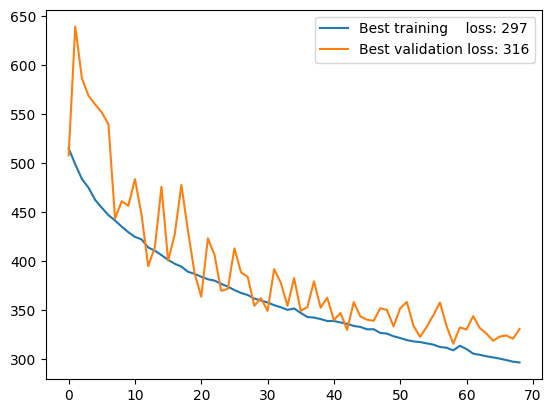

In [59]:
plt.plot(train_losses, label=f'Best training    loss: {min(train_losses):.0f}');
plt.plot(val_losses, label=f'Best validation loss: {min(val_losses):.0f}');
plt.legend();